# Import Libraries

In [129]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import folium

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import griddata

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pickle as pkl

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
curr_dir = (os.getcwd()).replace('\\', '/')
data_path = (os.path.join(curr_dir, 'Data')).replace('\\', '/')

In [141]:
str_sed_data = pd.read_csv(data_path + '/new_stream_sediments_57F11_2.csv')

In [143]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,yb,lu,hf,ta,w,u,toposheet,hg,cd,cluster
0,2947,2947,57F11/177/SS/12,77.657407,14.475225,61.921,14.606,4.51,0.05,2.28,...,2.290226,0.413697,26.874492,0.677483,2.5,3.016905,57F11,8.0,50.0,4
1,2948,2948,57F11/178/SS/12,77.675926,14.475225,62.077,13.750,4.22,0.05,2.43,...,2.891123,0.500104,37.079419,0.774466,2.5,3.378550,57F11,9.0,50.0,4
2,2949,2949,57F11/179/SS/12,77.694444,14.475225,68.645,13.410,3.02,0.05,1.32,...,2.323000,0.423000,23.652000,0.715000,2.5,3.509000,57F11,2.5,50.0,1
3,2950,2950,57F11/180/SS/12,77.712963,14.475225,64.950,14.280,3.46,0.05,1.75,...,2.186000,0.400000,21.961000,0.744000,2.5,4.241000,57F11,15.0,50.0,1
4,2951,2951,57F11/181/SS/12,77.731481,14.475225,64.302,14.010,4.08,0.05,1.84,...,2.322000,0.431000,26.705000,0.832000,2.5,4.218000,57F11,15.0,50.0,4


# EDA

In [144]:
str_elem = []

for col in list(str_sed_data.columns):
    if col not in ['gid', 
                   'objectid', 
                   'sampleno', 
                   'longitude', 
                   'latitude', 
                   'toposheet']:
        str_elem.append(col)

str_elem_df = str_sed_data[str_elem]

In [145]:
str_elem_df.head()

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,tm,yb,lu,hf,ta,w,u,hg,cd,cluster
0,61.921,14.606,4.51,0.05,2.28,3.24,1.52,2.46,0.61,0.13,...,0.359742,2.290226,0.413697,26.874492,0.677483,2.5,3.016905,8.0,50.0,4
1,62.077,13.750,4.22,0.05,2.43,4.14,1.52,2.55,0.64,0.12,...,0.419132,2.891123,0.500104,37.079419,0.774466,2.5,3.378550,9.0,50.0,4
2,68.645,13.410,3.02,0.05,1.32,3.19,2.89,3.08,0.75,0.08,...,0.329000,2.323000,0.423000,23.652000,0.715000,2.5,3.509000,2.5,50.0,1
3,64.950,14.280,3.46,0.05,1.75,3.10,2.34,2.82,0.60,0.12,...,0.306000,2.186000,0.400000,21.961000,0.744000,2.5,4.241000,15.0,50.0,1
4,64.302,14.010,4.08,0.05,1.84,3.24,2.12,2.83,0.75,0.16,...,0.334000,2.322000,0.431000,26.705000,0.832000,2.5,4.218000,15.0,50.0,4


## Concentration of elements in each cluster

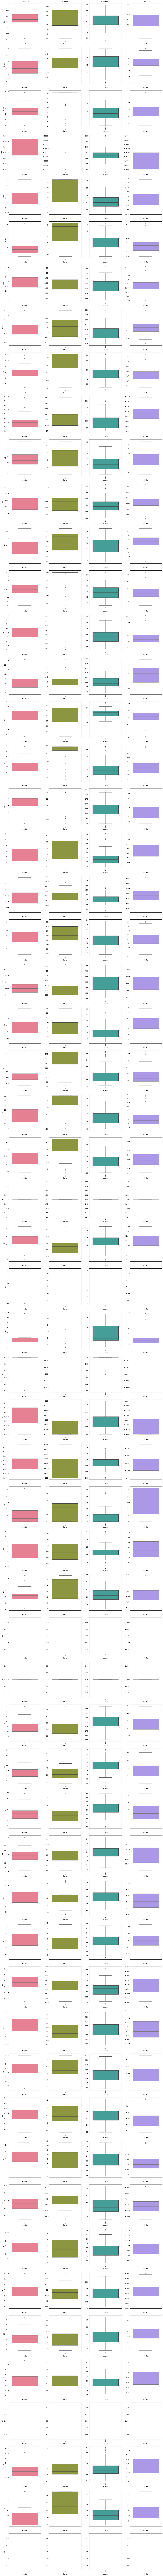

In [153]:
n_elem = len(str_elem_df.columns) - 1
n_clstr = len(str_elem_df['cluster'].unique())
# col_pal = ['#bfeeff', '#a8c5dd', '#a9a2b8', '#a58b91']
col_pal = sns.color_palette("husl", n_clstr)

fig, axes = plt.subplots(nrows=n_elem, 
                         ncols=n_clstr, 
                         figsize=(15, 4 * n_elem))

# If only one row or one column, axes need to be reshaped into a 2D array for consistency in indexing
if n_elem == 1:
    axes = np.expand_dims(axes, 
                          axis=0)
if n_clstr == 1:
    axes = np.expand_dims(axes, 
                          axis=1)

# Loop through each element
for i, element in enumerate(str_elem_df.columns[:-1]):  # assuming the last column is 'cluster'
    for cluster in range(1, n_clstr+1):
        # Filter data for the current cluster
        cluster_data = str_elem_df[str_elem_df['cluster'] == cluster]
        
        # Create boxplot for the current element in the current cluster subplot
        sns.boxplot(x='cluster', 
                    y=element, 
                    data=cluster_data, 
                    ax=axes[i, cluster-1], 
                    palette=[col_pal[cluster-1]])
        
        # Set titles and labels appropriately
        if i == 0:
            axes[i, cluster-1].set_title(f'Cluster {cluster}')
        if cluster == 1:
            axes[i, cluster-1].set_ylabel(element)
        else:
            axes[i, cluster-1].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()

## Heatmap for dominant elements among clusters

In [154]:
cluster_mean = str_elem_df.groupby('cluster')[str_elem].mean()
cluster_mean.drop(['cluster'], axis=1, inplace=True)

In [155]:
cluster_mean

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,er,tm,yb,lu,hf,ta,w,u,hg,cd
cluster,,,,,,,,,,,,,,,,,,,,,
1,64.964317,15.140643,3.709048,0.049762,1.234762,2.808929,2.569048,2.705476,0.606429,0.104881,...,1.630407,0.277718,1.885913,0.329363,21.534402,0.686038,2.5,2.738299,5.976190,50.0
2,52.682960,15.981880,7.630800,0.098400,2.761800,5.389800,1.441200,1.236800,1.049000,0.096800,...,2.559876,0.448803,2.930084,0.475244,7.296709,0.670041,2.5,1.522598,11.360000,50.0
3,62.579793,15.309015,4.823456,0.066912,1.558824,3.378603,2.180294,2.382059,0.715147,0.100294,...,2.244035,0.375761,2.479428,0.420549,17.842443,0.789239,2.5,2.524582,6.169118,50.0
4,61.753058,15.268809,4.771691,0.061471,1.607500,3.240882,2.128088,2.722794,0.733971,0.152059,...,2.353318,0.396650,2.654589,0.469248,28.000999,0.900263,2.5,3.820439,7.757353,50.0


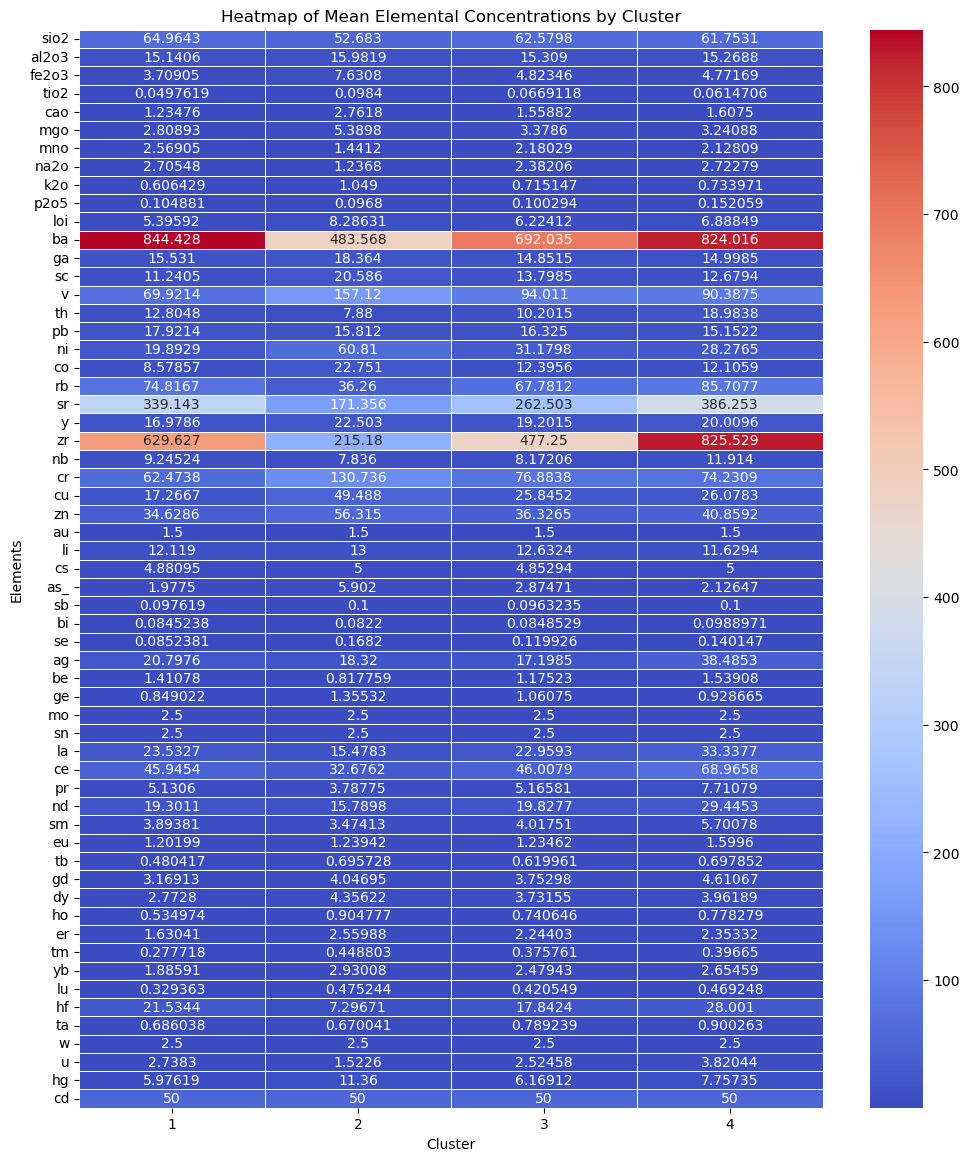

In [158]:
plt.figure(figsize=(12, 14))
heatmap = sns.heatmap(cluster_mean.T, 
                      annot=True, 
                      cmap='coolwarm', 
                      linewidths=.5, 
                      fmt='g')
heatmap.set_title('Heatmap of Mean Elemental Concentrations by Cluster')
heatmap.set_xlabel('Cluster')
heatmap.set_ylabel('Elements')
plt.show()

In [12]:
elem_clstr_df = pd.DataFrame(columns=['clutser 1', 'clutser 2', 'clutser 3'])
elem_clstr_df.loc[0] = ['Vanadium', np.NaN, 'Strontium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Arsenic', np.NaN, 'Barium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Chromium', np.NaN, 'Zirconium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Nickel', np.NaN, 'Neodymium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Gallium', np.NaN, 'Rubidium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Copper', np.NaN, 'Praseodymium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Zinc', np.NaN, 'Silver']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Scandium', np.NaN, 'Cerium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Cobalt', np.NaN, 'Thorium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Gold', np.NaN, 'Lanthanum']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Mercury', np.NaN, 'Hafnium']

In [13]:
elem_clstr_df

,clutser 1,clutser 2,clutser 3
0,Vanadium,NaN,Strontium
1,Arsenic,NaN,Barium
2,Chromium,NaN,Zirconium
3,Nickel,NaN,Neodymium
4,Gallium,NaN,Rubidium
5,Copper,NaN,Praseodymium
6,Zinc,NaN,Silver
7,Scandium,NaN,Cerium
8,Cobalt,NaN,Thorium
9,Gold,NaN,Lanthanum


In [ ]:
elem_clstr_df = pd.DataFrame(columns=['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4'])
elem_clstr_df.loc[0] = ['Vanadium', np.NaN, 'Strontium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Arsenic', np.NaN, 'Barium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Chromium', np.NaN, 'Zirconium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Nickel', np.NaN, 'Neodymium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Gallium', np.NaN, 'Rubidium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Copper', np.NaN, 'Praseodymium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Zinc', np.NaN, 'Silver']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Scandium', np.NaN, 'Cerium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Cobalt', np.NaN, 'Thorium']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Gold', np.NaN, 'Lanthanum']
elem_clstr_df.loc[len(elem_clstr_df.index)] = ['Mercury', np.NaN, 'Hafnium']

In [14]:
clstr1_elem_df = cluster_mean[cluster_mean.index == 0][['v', 'as_', 'cr', 'ni', 'ga', 'cu', 'zn', 'sc', 'co', 'au', 'hg']]
clstr2_elem_df = cluster_mean[cluster_mean.index == 2][['sr', 'ba', 'zr', 'nd', 'rb', 'pr', 'ag', 'ce', 'th', 'la', 'hf']]

In [15]:
clstr1_elem_df

,v,as_,cr,ni,ga,cu,zn,sc,co,au,hg
cluster,,,,,,,,,,,
0,320.131818,20.060909,289.140909,92.231818,18.936364,65.654545,65.3,24.640909,36.727273,20.613636,16.772727


In [16]:
clstr2_elem_df

,sr,ba,zr,nd,rb,pr,ag,ce,th,la,hf
cluster,,,,,,,,,,,
2,388.29726,832.106849,842.473973,29.389561,85.875342,7.68695,55.246575,68.574088,19.539726,33.281071,28.702119


In [17]:
clstr1_df = str_sed_data[str_sed_data['cluster'] == 0][['gid', 'longitude', 'latitude'] + list(clstr1_elem_df.columns) + ['cluster']]
clstr1_df.reset_index(inplace=True, drop='index')
clstr1_df.head()

,gid,longitude,latitude,v,as_,cr,ni,ga,cu,zn,sc,co,au,hg,cluster
0,3604,77.509259,14.259009,347.0,24.0,883.0,249.0,20.0,75.0,61.0,26.0,54.0,16.0,15.0,0
1,3605,77.527778,14.259009,500.0,26.0,317.0,105.0,20.0,74.0,92.0,26.0,46.0,20.0,11.0,0
2,3606,77.546296,14.259009,353.0,21.0,357.0,101.0,22.0,56.0,71.0,24.0,41.0,1.5,10.0,0
3,3689,77.509259,14.277027,479.0,24.0,315.0,104.0,26.0,92.0,83.0,29.0,51.0,1.5,35.0,0
4,3690,77.527778,14.277027,382.0,30.0,293.0,81.0,20.0,57.0,77.0,23.0,37.0,1.5,10.0,0


In [18]:
clstr2_df = str_sed_data[str_sed_data['cluster'] == 2][['gid', 'longitude', 'latitude'] + list(clstr2_elem_df.columns) + ['cluster']]
clstr2_df.reset_index(inplace=True, drop='index')
clstr2_df.head()

,gid,longitude,latitude,sr,ba,zr,nd,rb,pr,ag,ce,th,la,hf,cluster
0,2947,77.657407,14.475225,375.7,826.5,695.4,31.887143,74.2,8.555444,25,72.232300,16.6,37.722005,26.874492,2
1,2948,77.675926,14.475225,465.2,836.2,826.1,28.995136,73.3,7.586066,24,63.086789,17.0,31.134342,37.079419,2
2,2951,77.731481,14.475225,405.8,770.5,1001.3,25.004000,86.8,6.659000,23,56.014999,23.1,27.639000,26.705000,2
3,2956,77.564815,14.493242,283.4,772.2,453.7,23.953863,63.6,6.265094,137,56.112010,9.8,26.657001,22.014712,2
4,2957,77.583333,14.493242,238.3,591.5,425.9,24.316941,64.8,6.554683,34,60.067221,9.3,29.094922,16.354219,2


## Contour Maps

In [139]:
def plot_contour(df, element, title):

    min_lat_limit = min(df['latitude']) - 0.005
    max_lat_limit = max(df['latitude']) + 0.005
    min_long_limit = min(df['longitude']) - 0.005 
    max_long_limit = max(df['longitude']) + 0.005

    grid_x, grid_y = np.mgrid[
        min_long_limit:max_long_limit:100j,  # 100j specifies 100 points in grid
        min_lat_limit:max_lat_limit:100j
    ]

    # Grid interpolation
    grid_z = griddata(
        (df['longitude'], df['latitude']),
        df[element],
        (grid_x, grid_y),
        method='cubic'  # 'cubic' for smoother contour lines
    )

    cmap = LinearSegmentedColormap.from_list("green_to_red", ["green", "yellow", "red"])
    # Plotting
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(grid_x, 
                      grid_y, 
                      grid_z, 
                      levels=15, 
                      cmap=cmap)  # contour map
    
    plt.colorbar(cp)  # add colorbar
    plt.title(f'{title}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.scatter(df['longitude'], 
                df['latitude'], 
                color='red', 
                label='Sample Points')  # data points
    plt.legend()

    for i, (x, y) in enumerate(zip(df['longitude'], df['latitude'])):
        plt.text(x, y, str(i+1), color='black', fontsize=8)
    
    plt.show()

### Contour map for Silver

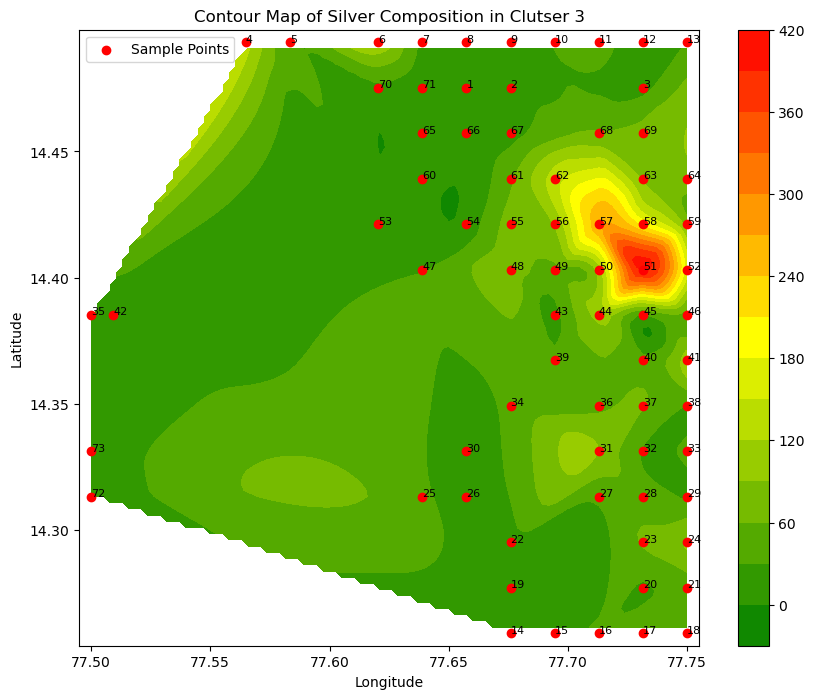

In [140]:
plot_contour(clstr2_df, 'ag', 'Contour Map of Silver Composition in Clutser 3')

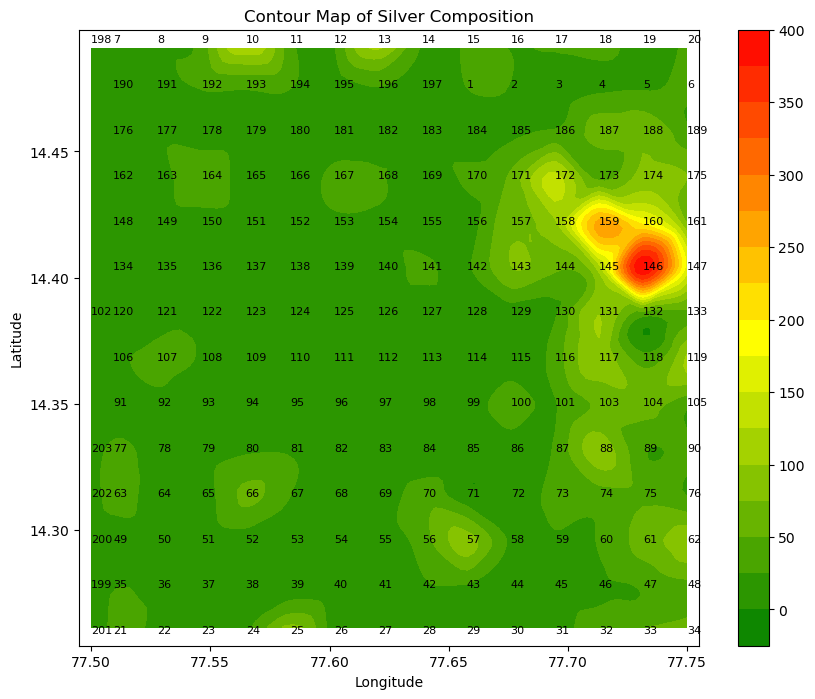

In [136]:
plot_contour(str_sed_data, 'ag', 'Contour Map of Silver Composition')

### Contour map for Arsenic

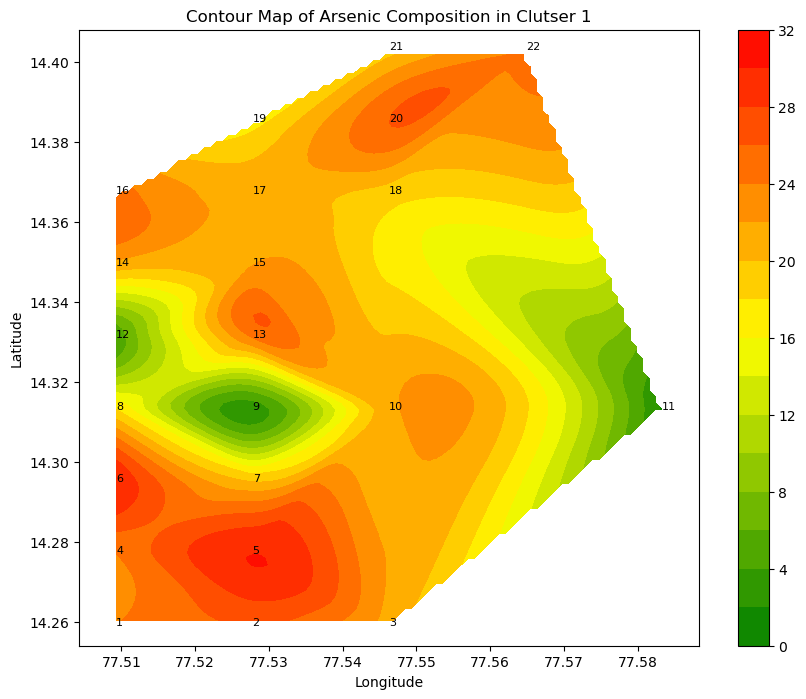

In [137]:
plot_contour(clstr1_df, 'as_', 'Contour Map of Arsenic Composition in Clutser 1')

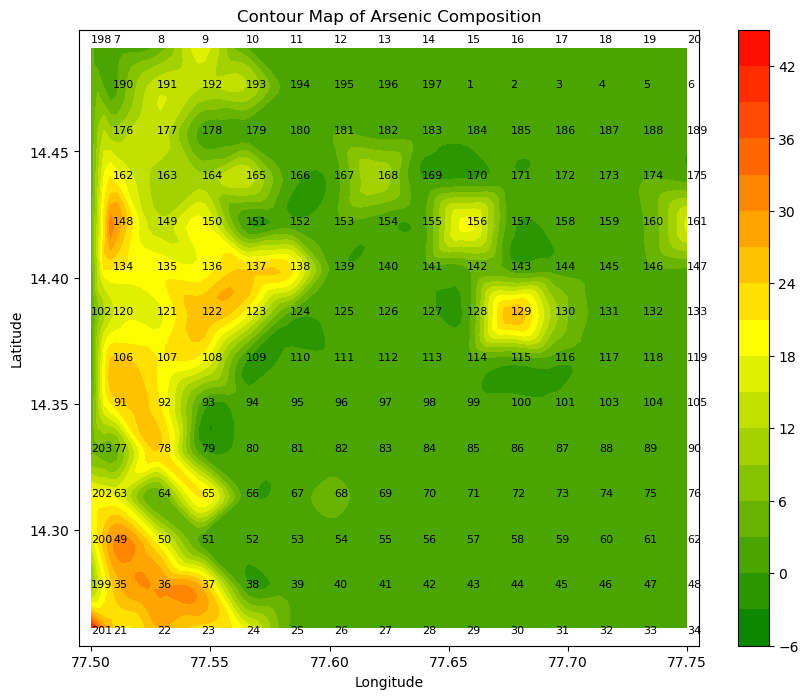

In [138]:
plot_contour(str_sed_data, 'as_', 'Contour Map of Arsenic Composition')